In [1]:
# Based on docs:
# https://docs.lightly.ai/self-supervised-learning/tutorials/package/tutorial_simclr_clothing.html

# Also, see:
# https://github.com/giakoumoglou/classification/blob/main/notebooks/main_simclr.ipynb
# https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html

## Imports

In [2]:
import os
from typing import Union, List, Tuple
from pathlib import Path
import shutil

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist

import pytorch_lightning as pl
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
from PIL import Image

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.preprocessing import normalize

from lightly.data import LightlyDataset
from lightly.transforms import SimCLRTransform, utils

from utils import (
    generate_embeddings_and_fnames,
    get_image_as_np_array,
    plot_knn_clusters,
    get_distance_between_points_in_cluster,
    get_distances_between_centroids,
    plot_clusters,
    generate_embeddings_and_fnames_simclr,
    check_labels_correspondence,
    plot_knn_examples,
    plot_clusters_3d,
)

## Configuration

We set some configuration parameters for our experiment.
Feel free to change them and analyze the effect.

The default configuration with a batch size of 256 and input resolution of 128
requires 6GB of GPU memory.



In [3]:
input_size = 32  # laptop
# input_size = 128  # PC
batch_size = 64  # laptop
# batch_size = 256  # PC

num_workers = 8
seed = 1
max_epochs = 10
num_ftrs = 32

Let's set the seed for our experiments



In [4]:
pl.seed_everything(seed)

Seed set to 1


1

In [5]:
# Create the directory if it doesn't exist
os.makedirs("./datasets/mnist", exist_ok=True)
os.makedirs("./datasets/mnist/train", exist_ok=True)
os.makedirs("./datasets/mnist/test", exist_ok=True)

In [6]:
# Download the MNIST dataset (if not already downloaded)
train_dataset = datasets.MNIST(root="./datasets/mnist", train=True, download=True)
test_dataset = datasets.MNIST(root="./datasets/mnist", train=False, download=True)

In [7]:
print(type(test_dataset.targets))
print(test_dataset.targets.shape)
print(test_dataset.targets[:10])
print(test_dataset.targets.unique(return_counts=True))

<class 'torch.Tensor'>
torch.Size([10000])
tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9])
(tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), tensor([ 980, 1135, 1032, 1010,  982,  892,  958, 1028,  974, 1009]))


In [8]:
# Save the images to the directory
for i, (image, label) in enumerate(train_dataset):
    image.save(f"./datasets/mnist/train/{i}.png")

for i, (image, label) in enumerate(test_dataset):
    image.save(f"./datasets/mnist/test/{i}.png")

In [9]:
# Remove original data to prevent errors (if it exists)
# if os.path.exists("./datasets/mnist/MNIST"):
# shutil.rmtree("./datasets/mnist/MNIST")

In [10]:
path_to_data = r"./datasets/mnist"
path_to_train_data = Path(path_to_data) / "train"
path_to_test_data = Path(path_to_data) / "test"

## Setup data augmentations and loaders

The images from the dataset have been taken from above when the clothing was
on a table, bed or floor. Therefore, we can make use of additional augmentations
such as vertical flip or random rotation (90 degrees).
By adding these augmentations we learn our model invariance regarding the
orientation of the clothing piece. E.g. we don't care if a shirt is upside down
but more about the strcture which make it a shirt.

You can learn more about the different augmentations and learned invariances
here: `lightly-advanced`.



In [11]:
transform = SimCLRTransform(input_size=input_size, vf_prob=0.5, rr_prob=0.5)

# We create a torchvision transformation for embedding the dataset after
# training
test_transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize((input_size, input_size)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            mean=(0.5,), std=(0.5,)
        ),  # Adjusted for single-channel images
        # torchvision.transforms.Normalize(
        #     mean=utils.IMAGENET_NORMALIZE["mean"],
        #     std=utils.IMAGENET_NORMALIZE["std"],
        # ),
    ]
)

In [12]:
test_dataset = datasets.MNIST(
    root="./datasets/mnist", train=False, download=True, transform=test_transform
)

In [13]:
dataloader_test = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False
)

In [14]:
print(len(test_dataset))
print(test_dataset[0][1])
print(test_dataset[0][0].shape)

10000
7
torch.Size([1, 32, 32])


In [15]:
# dataset_train_simclr = LightlyDataset(input_dir=path_to_data, transform=transform)
train_dataset_simclr = LightlyDataset(input_dir=path_to_train_data, transform=transform)

# dataset_test = LightlyDataset(input_dir=path_to_data, transform=test_transform)
test_dataset_simclr = LightlyDataset(
    input_dir=path_to_test_data, transform=test_transform
)

In [16]:
print(len(train_dataset_simclr))
print(len(test_dataset_simclr))

60000
10000


In [17]:
dataloader_train_simclr = torch.utils.data.DataLoader(
    train_dataset_simclr,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers,
)

dataloader_test_simclr = torch.utils.data.DataLoader(
    test_dataset_simclr,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers,
)

In [18]:
for batch in dataloader_train_simclr:
    # batch_size = 256

    # as per docs (sample, target, fname)
    print("general")
    print(type(batch))
    print(len(batch))
    print()

    print("sample")
    print(type(batch[0]))
    print(len(batch[0]))
    print()

    print("sample[0]")
    print(type(batch[0][0]))
    print(len(batch[0][0]))
    print()

    print("sample[1]")
    print(type(batch[0][0]))
    print(len(batch[0][0]))
    print()

    print("target")
    print(type(batch[1]))
    print(batch[1].shape)
    print()

    print("target[0]")
    print(type(batch[1][0]))
    print(batch[1][0].shape)
    print(batch[1][0])
    print()

    print("target[1]")
    print(type(batch[1][1]))
    print(batch[1][1].shape)
    print()

    print("fname")
    print(type(batch[2]))
    print(len(batch[2]))
    print()

    print("fname[0]")
    print(type(batch[2][0]))
    print(batch[2][0])
    print()

    break

general
<class 'list'>
3

sample
<class 'list'>
2

sample[0]
<class 'torch.Tensor'>
64

sample[1]
<class 'torch.Tensor'>
64

target
<class 'torch.Tensor'>
torch.Size([64])

target[0]
<class 'torch.Tensor'>
torch.Size([])
tensor(0)

target[1]
<class 'torch.Tensor'>
torch.Size([])

fname
<class 'tuple'>
64

fname[0]
<class 'str'>
32401.png



## Create the SimCLR Model
Now we create the SimCLR model. We implement it as a PyTorch Lightning Module
and use a ResNet-18 backbone from Torchvision. Lightly provides implementations
of the SimCLR projection head and loss function in the `SimCLRProjectionHead`
and `NTXentLoss` classes. We can simply import them and combine the building
blocks in the module.



In [19]:
from lightly.loss import NTXentLoss
from lightly.models.modules.heads import SimCLRProjectionHead


class SimCLRModel(pl.LightningModule):
    def __init__(self):
        super().__init__()

        # create a ResNet backbone and remove the classification head
        resnet = torchvision.models.resnet18()
        self.backbone = nn.Sequential(*list(resnet.children())[:-1])

        hidden_dim = resnet.fc.in_features
        self.projection_head = SimCLRProjectionHead(hidden_dim, hidden_dim, 128)

        self.criterion = NTXentLoss()

    def forward(self, x):
        h = self.backbone(x).flatten(start_dim=1)
        z = self.projection_head(h)
        return z

    def training_step(self, batch, batch_idx):
        (x0, x1), _, _ = batch
        z0 = self.forward(x0)
        z1 = self.forward(x1)
        loss = self.criterion(z0, z1)
        # TODO: dopisać inne metryki, które sprawdzają czy trening 'ma sens'
        # czyli np. czy klasy się zbliżyły do siebie i oddaliły od innych klas
        self.log("train_loss_ssl", loss)
        return loss

    def configure_optimizers(self):
        optim = torch.optim.SGD(
            self.parameters(), lr=6e-2, momentum=0.9, weight_decay=5e-4
        )
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, max_epochs)
        return [optim], [scheduler]

Train the module using the PyTorch Lightning Trainer on a single GPU.



In [20]:
# Uncomment for training (may take some time)

# model = SimCLRModel()
# trainer = pl.Trainer(max_epochs=max_epochs, devices=1, accelerator="gpu")
# trainer.fit(model, dataloader_train_simclr)

Next we create a helper function to generate embeddings
from our test images using the model we just trained.
Note that only the backbone is needed to generate embeddings,
the projection head is only required for the training.
Make sure to put the model into eval mode for this part!



In [21]:
# For eval only

# PC-trained model
model = SimCLRModel.load_from_checkpoint(
    "./lightning_logs/version_8/checkpoints/epoch=9-step=2340.ckpt"
)

# laptop-trained model
# maybe not-OK, as it was trained on 70k images (both train and test)
# model = SimCLRModel.load_from_checkpoint(
#     "./lightning_logs/version_0/checkpoints/epoch=9-step=10930.ckpt"
# )

In [22]:
model.eval()

SimCLRModel(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

In [23]:
embeddings, filenames = generate_embeddings_and_fnames_simclr(
    model, dataloader_test_simclr
)

In [24]:
# embeddings = generate_embeddings_and_fnames(model, dataloader_test)

## Visualize Clusters in Embedding Space
Let's look at the trained embedding how they're clustered in latent space.

In [25]:
kmeans = KMeans(n_clusters=10)

In [26]:
labels = kmeans.fit_predict(embeddings)

d:\__repos\ml_concepts\venv\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] Nie można odnaleźć określonego pliku
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "d:\__repos\ml_concepts\venv\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "C:\Users\Maciek\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 501, in run
    with Popen(*popenargs, **kwargs) as process:
  File "C:\Users\Maciek\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 966, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\Maciek\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 1435, in _execute_child
    hp, ht, pid

In [27]:
labels[0:20]

array([5, 1, 4, 1, 7, 9, 2, 3, 0, 0, 6, 6, 0, 4, 4, 5, 0, 0, 6, 9])

In [28]:
test_dataset.targets[0:20]

tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4])

In [29]:
np.unique(labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [30]:
get_distance_between_points_in_cluster(embeddings, labels)

{'0': 0.19087124618708567,
 '1': 0.32597644758629113,
 '2': 0.2613299428197533,
 '3': 0.2638265215389464,
 '4': 0.2577451762396796,
 '5': 0.26147515645203523,
 '6': 0.24003661709213012,
 '7': 0.23464702260899006,
 '8': 0.2765338123987538,
 '9': 0.2740312628149653}

In [31]:
distances = get_distances_between_centroids(embeddings)

Cluster centroids dimensions: (10, 512)
Cluster centroids:
 [[3.31920902e-02 1.08098020e-02 1.00518232e-02 ... 4.15575731e-02
  3.31599327e-02 7.85242645e-03]
 [4.26137328e-02 1.06652781e-02 2.46919854e-06 ... 2.67948781e-02
  1.93527347e-03 8.66989562e-06]
 [3.32334977e-02 1.08356713e-02 2.16913052e-03 ... 5.78720703e-02
  2.23077962e-02 7.67541221e-03]
 ...
 [2.98962129e-02 9.83391185e-03 3.24522463e-02 ... 4.62475886e-02
  5.71238911e-02 6.95042545e-03]
 [3.81456690e-02 8.88214829e-03 9.04367784e-04 ... 1.43049618e-02
  9.96815657e-03 7.12638381e-04]
 [3.57012312e-02 8.66107531e-03 3.08356841e-04 ... 4.89105910e-02
  1.65003188e-02 2.43176289e-03]]
Cluster sizes: [1021 1197 1238 1805  523  805  783 1111  632  885]


In [32]:
print(f"Distances shape: {distances.shape}")
print(f"Distances rank: {np.linalg.matrix_rank(distances)}")
print(f"Distancess:\n {distances}")

Distances shape: (10, 10)
Distances rank: 10
Distancess:
 [[0.         0.44818652 0.20731289 0.27881131 0.27358459 0.36147635
  0.27981739 0.24270746 0.31740625 0.21033386]
 [0.44818652 0.         0.48446021 0.24537753 0.56197557 0.25037661
  0.47813071 0.64108867 0.3062589  0.36197127]
 [0.20731289 0.48446021 0.         0.29123191 0.24063295 0.40129816
  0.23476722 0.28556515 0.32410286 0.2255243 ]
 [0.27881131 0.24537753 0.29123191 0.         0.42508864 0.26377735
  0.2728879  0.48566165 0.24240683 0.21683023]
 [0.27358459 0.56197557 0.24063295 0.42508864 0.         0.47137367
  0.38185944 0.2719824  0.33369852 0.33568115]
 [0.36147635 0.25037661 0.40129816 0.26377735 0.47137367 0.
  0.42255313 0.53790841 0.32023346 0.21893943]
 [0.27981739 0.47813071 0.23476722 0.2728879  0.38185944 0.42255313
  0.         0.40486599 0.38345194 0.27512733]
 [0.24270746 0.64108867 0.28556515 0.48566165 0.2719824  0.53790841
  0.40486599 0.         0.4883549  0.38386251]
 [0.31740625 0.3062589  0.3241

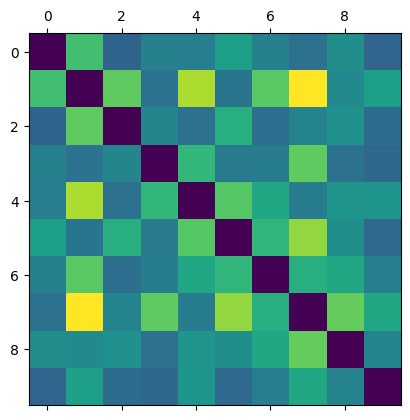

In [33]:
plt.matshow(distances, cmap="viridis")

In [34]:
visualization_df = pd.DataFrame(distances)
print(visualization_df)

          0         1         2         3         4         5         6  \
0  0.000000  0.448187  0.207313  0.278811  0.273585  0.361476  0.279817   
1  0.448187  0.000000  0.484460  0.245378  0.561976  0.250377  0.478131   
2  0.207313  0.484460  0.000000  0.291232  0.240633  0.401298  0.234767   
3  0.278811  0.245378  0.291232  0.000000  0.425089  0.263777  0.272888   
4  0.273585  0.561976  0.240633  0.425089  0.000000  0.471374  0.381859   
5  0.361476  0.250377  0.401298  0.263777  0.471374  0.000000  0.422553   
6  0.279817  0.478131  0.234767  0.272888  0.381859  0.422553  0.000000   
7  0.242707  0.641089  0.285565  0.485662  0.271982  0.537908  0.404866   
8  0.317406  0.306259  0.324103  0.242407  0.333699  0.320233  0.383452   
9  0.210334  0.361971  0.225524  0.216830  0.335681  0.218939  0.275127   

          7         8         9  
0  0.242707  0.317406  0.210334  
1  0.641089  0.306259  0.361971  
2  0.285565  0.324103  0.225524  
3  0.485662  0.242407  0.216830  
4  0

## Visualize Nearest Neighbors
Let's look at the trained embedding and visualize the nearest neighbors for
a few random samples.

We create some helper functions to simplify the work



In [35]:
def plot_knn_examples(
    embeddings, filenames, path_to_data, n_neighbors=3, num_examples=6
):
    """Plots multiple rows of random images with their nearest neighbors"""
    # lets look at the nearest neighbors for some samples
    # we use the sklearn library
    nbrs = NearestNeighbors(n_neighbors=n_neighbors).fit(embeddings)
    distances, indices = nbrs.kneighbors(embeddings)

    # get 5 random samples
    samples_idx = np.random.choice(len(indices), size=num_examples, replace=False)

    # loop through our randomly picked samples
    for idx in samples_idx:
        fig = plt.figure()
        # loop through their nearest neighbors
        for plot_x_offset, neighbor_idx in enumerate(indices[idx]):
            # add the subplot
            ax = fig.add_subplot(1, len(indices[idx]), plot_x_offset + 1)
            # get the correponding filename for the current index
            fname = os.path.join(path_to_data, filenames[neighbor_idx])
            # plot the image
            plt.imshow(get_image_as_np_array(fname))
            # set the title to the distance of the neighbor
            ax.set_title(f"d={distances[idx][plot_x_offset]:.3f}")
            # let's disable the axis
            plt.axis("off")

In [36]:
# plot_knn_examples(
#     embeddings, filenames, n_neighbors=7, num_examples=10, path_to_data=path_to_data
# )

## Visualize Nearest Neighbours on 2D Plane
Let's look at the trained embedding, perform KNN, then PCA and visualize clusters in 2D space.

In [37]:
plot_knn_clusters(
    embeddings, np.array(test_dataset.targets), n_neighbors=5, num_examples=10
)

Indices shape: (10000, 5)
Sampled indices: [5402 1988  254 1266 5075 2336 5009 4859  793 5397]
Original label: 7
Predicted label: [7 6 1 4 8]
Original label: 1
Predicted label: [1 4 4 5 9]
Original label: 7
Predicted label: [7 4 5 0 7]
Original label: 6
Predicted label: [6 3 2 0 1]
Original label: 8
Predicted label: [8 4 6 1 7]
Original label: 4
Predicted label: [4 2 7 2 6]
Original label: 9
Predicted label: [9 8 2 5 8]
Original label: 1
Predicted label: [1 8 0 3 7]
Original label: 8
Predicted label: [8 6 4 5 0]
Original label: 5
Predicted label: [5 0 9 1 6]


## Visualize Clusters on 2D Plane
Let's look at the trained embedding, perform PCA and visualize clusters in 2D space.

In [38]:
# MNIST 'labels' created by simclr
print(type(test_dataset_simclr.dataset.targets))
unique_targets = np.unique(test_dataset_simclr.dataset.targets)
print(unique_targets)
print(test_dataset_simclr.dataset.targets[0])
print(type(test_dataset_simclr.dataset.targets[0]))

<class 'list'>
[0]
0
<class 'int'>


In [39]:
# original MNIST labels
print(type(test_dataset.targets))
unique_targets = np.unique(test_dataset.targets)
print(unique_targets)
print(test_dataset.targets[0])
print(type(test_dataset.targets[0]))

<class 'torch.Tensor'>
[0 1 2 3 4 5 6 7 8 9]
tensor(7)
<class 'torch.Tensor'>


Working on embeddings of shape torch.Size([10000, 512])
Filtering to labels [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]: 10000 points left
Plotting 100 points out of 10000
Some labels: [0 4 7 5 9 1 8 7 6 3]


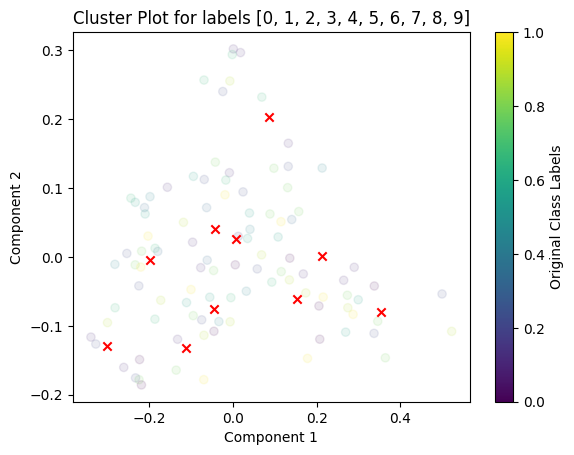

In [40]:
plot_clusters(
    embeddings,
    np.array(test_dataset.targets),
    proportion_of_points_to_plot=0.01,
    alpha=0.1,
    plot_centroids=True,
    specific_labels=list(range(10)),
)

Working on embeddings of shape torch.Size([10000, 512])
Filtering to labels [0, 1, 2, 3]: 4157 points left
Plotting 2078 points out of 4157
Some labels: [1 0 1 0 0 0 1 0 2 3]


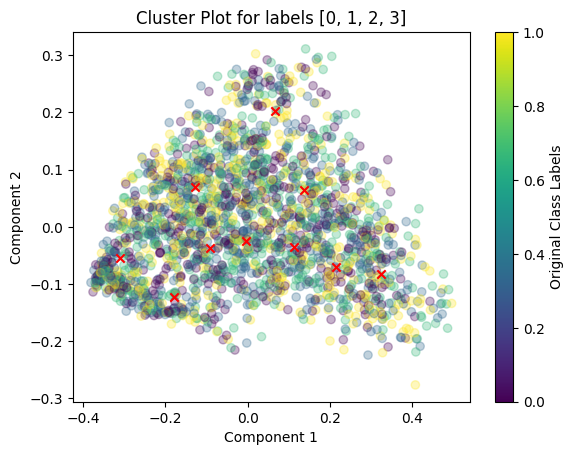

In [41]:
plot_clusters(
    embeddings,
    np.array(test_dataset.targets),
    proportion_of_points_to_plot=0.5,
    alpha=0.3,
    plot_centroids=True,
    specific_labels=[0, 1, 2, 3],
)

Working on embeddings of shape torch.Size([10000, 512])
Filtering to labels [0, 8]: 1954 points left
Plotting 977 points out of 1954
Some labels: [8 0 8 0 8 0 0 8 8 0]


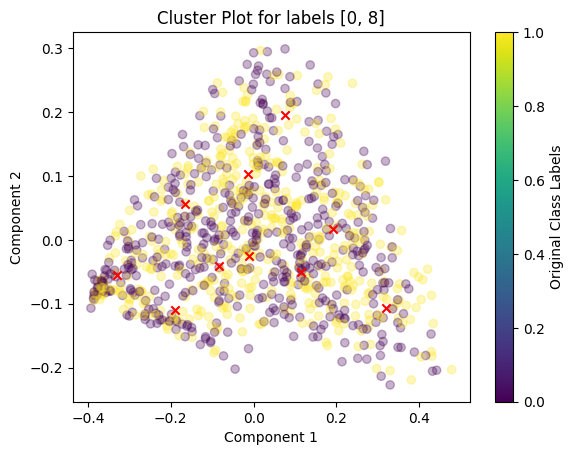

In [42]:
plot_clusters(
    embeddings,
    np.array(test_dataset.targets),
    proportion_of_points_to_plot=0.5,
    alpha=0.3,
    plot_centroids=True,
    specific_labels=[0, 8],
)

Working on embeddings of shape torch.Size([10000, 512])
Filtering to labels [1, 4]: 2117 points left
Plotting 1058 points out of 2117
Some labels: [1 1 4 4 1 4 4 4 1 1]


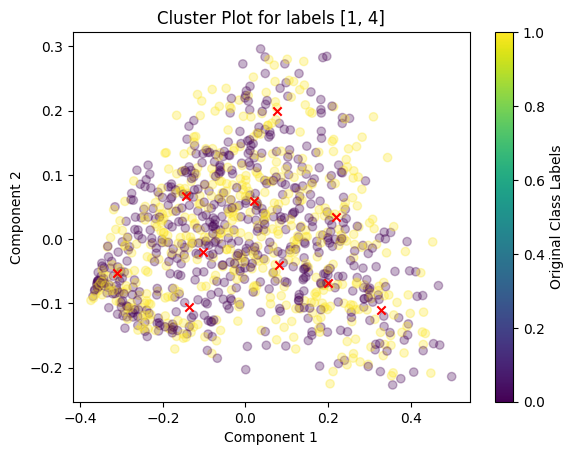

In [43]:
plot_clusters(
    embeddings,
    np.array(test_dataset.targets),
    proportion_of_points_to_plot=0.5,
    alpha=0.3,
    plot_centroids=True,
    specific_labels=[1, 4],
)

Working on embeddings of shape torch.Size([10000, 512])
Filtering to labels [2, 3, 5, 8]: 3908 points left
Plotting 1954 points out of 3908
Some labels: [3 2 3 3 2 3 8 2 8 2]


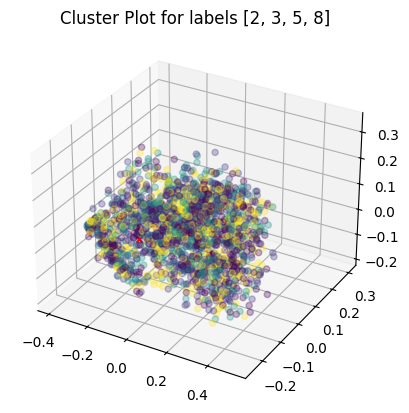

In [44]:
plot_clusters_3d(
    embeddings,
    np.array(test_dataset.targets),
    proportion_of_points_to_plot=0.5,
    alpha=0.3,
    plot_centroids=True,
    specific_labels=[2, 3, 5, 8],
)

Working on embeddings of shape torch.Size([10000, 512])
Filtering to labels [2, 3, 5, 8]: 3908 points left
Plotting 1954 points out of 3908
Some labels: [5 3 3 8 5 5 5 3 3 2]


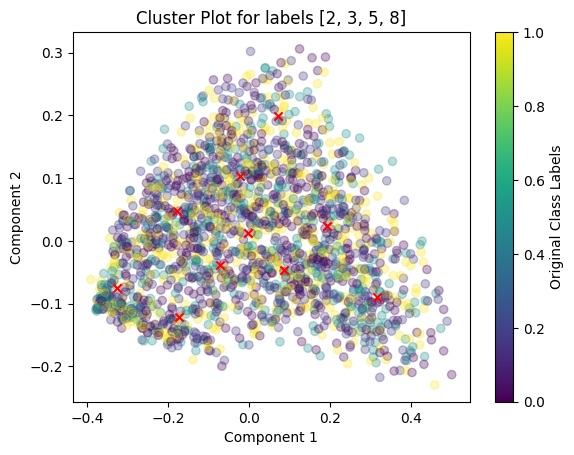

In [45]:
plot_clusters(
    embeddings,
    np.array(test_dataset.targets),
    proportion_of_points_to_plot=0.5,
    alpha=0.3,
    plot_centroids=True,
    specific_labels=[2, 3, 5, 8],
)

Working on embeddings of shape torch.Size([10000, 512])
Filtering to labels [1, 8]: 2109 points left
Plotting 1054 points out of 2109
Some labels: [8 8 8 1 8 8 8 1 8 1]


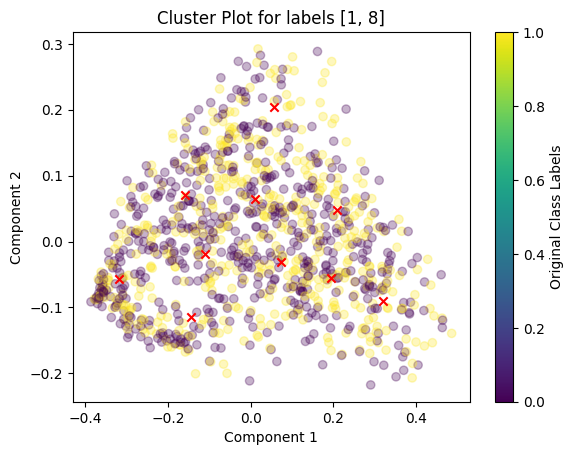

In [46]:
plot_clusters(
    embeddings,
    np.array(test_dataset.targets),
    proportion_of_points_to_plot=0.5,
    alpha=0.3,
    plot_centroids=True,
    specific_labels=[1, 8],
)

## Check Labels Correspoding to Clusters
Let's check if the clusters in the embedding space correspond to the labels of the images.

Unique labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


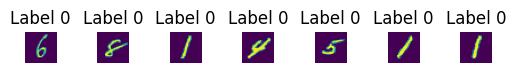

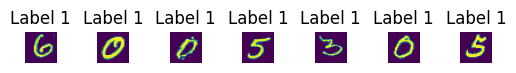

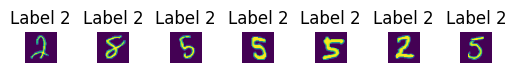

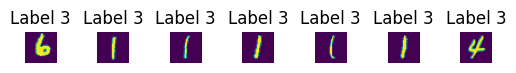

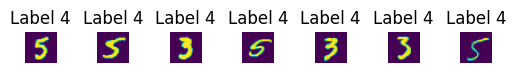

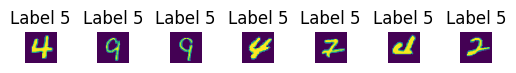

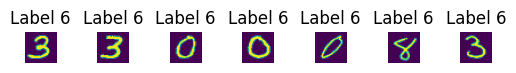

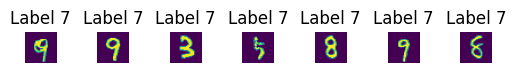

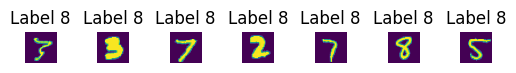

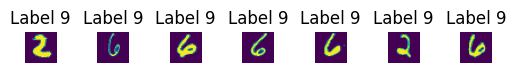

In [47]:
check_labels_correspondence(
    embeddings=embeddings, base_path=path_to_test_data, filenames=filenames
)

## Simple clustering on MNIST
Let's check if it's possible to create good clusters from MNIST, working in pixel space.

In [48]:
test_dataset.targets[0:10]

tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9])

In [49]:
len(test_dataset.test_data)

d:\__repos\ml_concepts\venv\lib\site-packages\torchvision\datasets\mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


10000

In [50]:
test_dataset.data[0].shape

torch.Size([28, 28])

In [51]:
mnist_clusters = KMeans(n_clusters=10).fit(test_dataset.data.reshape(-1, 28 * 28))

In [52]:
np.unique(mnist_clusters.labels_, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([1090, 1072, 1628,  480, 1010,  618,  854, 1202,  841, 1205],
       dtype=int64))

Working on embeddings of shape torch.Size([10000, 784])
Filtering to labels [0, 4, 7]: 2990 points left
Plotting 1196 points out of 2990
Some labels: [7 0 0 0 7 0 4 7 4 4]


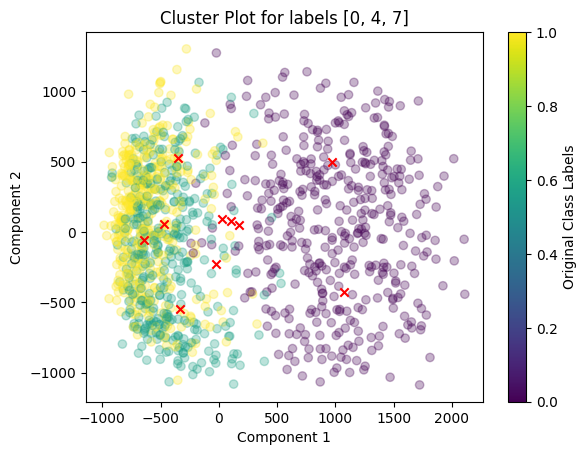

In [53]:
plot_clusters(
    test_dataset.data.reshape(-1, 28 * 28),
    np.array(test_dataset.targets),
    proportion_of_points_to_plot=0.4,
    alpha=0.3,
    plot_centroids=True,
    specific_labels=[0, 4, 7],
)

Working on embeddings of shape torch.Size([10000, 784])
Filtering to labels [0, 4, 7]: 2990 points left
Plotting 1196 points out of 2990
Some labels: [4 4 7 7 4 4 4 0 7 0]


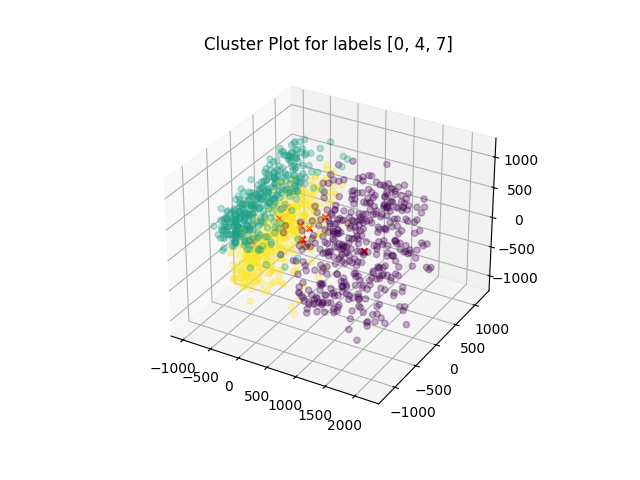

In [60]:
plot_clusters_3d(
    test_dataset.data.reshape(-1, 28 * 28),
    np.array(test_dataset.targets),
    proportion_of_points_to_plot=0.4,
    alpha=0.3,
    plot_centroids=True,
    specific_labels=[0, 4, 7],
)

In [54]:
proportion_of_points_to_plot = 0.4
num_clusters = 20
alpha = 0.3

In [55]:
kmeans = KMeans(n_clusters=num_clusters)
labels = kmeans.fit_predict(embeddings)
centroids = kmeans.cluster_centers_

In [56]:
sampled_indices = np.random.choice(
    embeddings.shape[0],
    int(len(embeddings) * proportion_of_points_to_plot),
    replace=False,
)

In [57]:
%matplotlib widget

Plotting 4000 points out of 10000
PCA(n_components=3)
(4000, 3)
(20, 3)


C:\Users\Maciek\AppData\Local\Temp\ipykernel_15100\62715347.py:16: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(


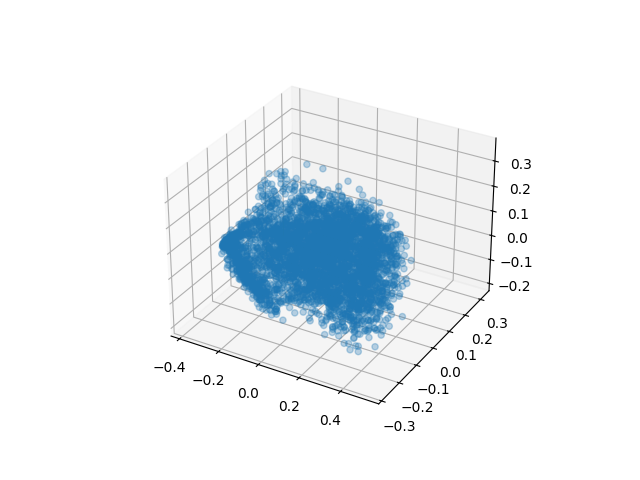

In [58]:
sampled_embeddings = embeddings[sampled_indices]

print(f"Plotting {len(sampled_embeddings)} points out of {len(embeddings)}")

ax = plt.figure().add_subplot(projection="3d")

pca = PCA(n_components=3)
print(pca)

to_plot_embeddings = pca.fit_transform(sampled_embeddings)
print(to_plot_embeddings.shape)

to_plot_centroids = pca.transform(centroids)
print(to_plot_centroids.shape)

ax.scatter(
    to_plot_embeddings[:, 0],
    to_plot_embeddings[:, 1],
    to_plot_embeddings[:, 2],
    alpha=alpha,
    cmap="viridis",
)

plt.show()

In [59]:
plot_clusters(
    test_dataset.data.reshape(-1, 28 * 28),
    np.array(test_dataset.targets),
    proportion_of_points_to_plot=0.4,
    alpha=0.3,
    plot_centroids=True,
    specific_labels=[1, 4, 7],
)

Working on embeddings of shape torch.Size([10000, 784])
Filtering to labels [1, 4, 7]: 3145 points left
Plotting 1258 points out of 3145
Some labels: [1 1 1 7 7 1 1 1 4 4]


ValueError: s must be a scalar, or float array-like with the same size as x and y

Working on embeddings of shape torch.Size([10000, 784])
Filtering to labels [2, 3, 5, 8]: 3908 points left
Plotting 1563 points out of 3908
Some labels: [2 8 8 2 3 3 5 2 2 5]


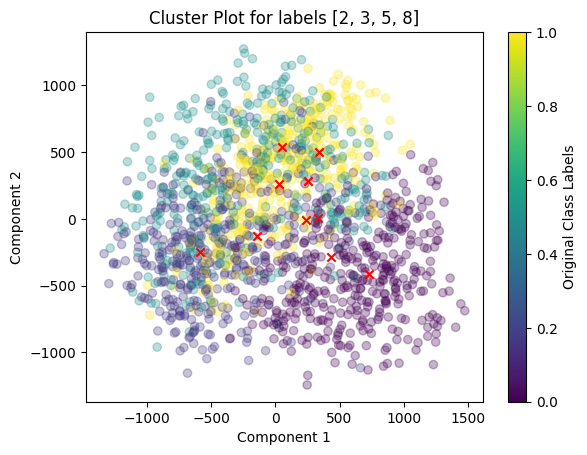

In [ ]:
plot_clusters(
    test_dataset.data.reshape(-1, 28 * 28),
    np.array(test_dataset.targets),
    proportion_of_points_to_plot=0.4,
    alpha=0.3,
    plot_centroids=True,
    specific_labels=[2, 3, 5, 8],
)